In [1]:
###################################################################
# First Project : Reinforcement Learning and Dynamic Optimzation  #
# Author : Toganidis Nikos (2018030085)                           #
# Date : 17/04/2023                                               #
# ----------------------------------------------------------------##################################
# For this Exercise, the goal was to learn to predict the least loaded server at every time round, #
# given a dataset of real traffic loads over time (normalized), for a number of servers. We        #
# created an Experts Enviroment and an adversarial Bandits enviroment and applied the Multiplicate #
# Weight / Hedge algorithm for both enviroments and compared the results. We also                  #
# applied a variant of the UCB algorithm for the adversarial bandit enviroment and we compared its #
# results with the Hedge algorithm on the adversarial bandit enviroment.                           #
####################################################################################################

# Import Libraries we need

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random

Here we import the necessary libraries

In [2]:
##################################################################
#                          FUNCTIONS                             #
##################################################################

# Multiplicate Weight Algorithm for Experts Enviroment


def Hedge_Experts(time, w, loss, prob, dataset, alg_loss):

    experts = dataset.shape[0]
    eta = 0.2  # math.sqrt(math.log(experts)/T)  # Algorithm's parameter

    # Choose random the expert according to current picking probabilities
    choose_expert = random.choices(range(len(prob)), weights=prob)[0]
    # Calculate the load of the chosen expert
    Current_expert_load = dataset[time][choose_expert]
    # Calculate the minimum load of the experts
    min_load = np.min(dataset[time][:])
    alg_loss[time] = Current_expert_load - min_load
    # Calculate all losses and update weights
    for i in range(experts):
        loss[i] = dataset[time][i] - min_load  # Update the losses
        w[i] *= math.pow((1-eta), loss[i])  # Update the weights

Multiplicate Weight Algorithm for Experts Enviroment. We choose an expert randomly according to their probabilities ( which depend on the expert weights ). Then we find the minimum load of servers and compare it with the load of the chosen expert to calculate the loss. We update the loss of each expert and their weights. Its worth to note that we change the probabilities before the call of this function. Also, eta = 0.2 < 0.5, cause for this value the algorithm gives better results ( instead of using the formula at the comment )

In [3]:
# ----------------------------------------------------------------------------------
# Multiplicate Weight Algorithm for Bandit Enviroment


def Hedge_Bandits(time, w, loss, prob, dataset, alg_loss):

    bandits = dataset.shape[0]
    # math.sqrt(math.log(experts)/T)  # Algorithm's parameter
    eta = 0.2  # (bandits*math.log(bandits)/T)**(1/3)
    gamma = 0.05  # Exploration - Exploitation tradeoff / Parameter

    #  Add some exploration
    q = (1-gamma)*prob + gamma/bandits

    # Choose random the expert according to current picking probabilities
    choose_expert = random.choices(range(len(q)), weights=q)[0]
    # Calculate the min value
    min_v = np.min(dataset[time][:])
    # Receive only loss of the chosen arm
    loss[choose_expert] = dataset[time][choose_expert] - min_v
    alg_loss[time] = loss[choose_expert]
    # Calculate The hat Loss
    loss_hat = np.zeros(bandits)
    loss_hat[choose_expert] = loss[choose_expert]/q[choose_expert]
    # Update the weights
    for i in range(bandits):
        w[i] *= math.pow((1-eta), loss_hat[i])

Multipicate Weight / Hedge algorithm for aversarial bandits enviroment. The logic behind this algorithm is almost the same with the one for the expert enviroment. The only differences are that in this case, we get to know only the loss of the bandit we picked. We also have the parameter gamma for the tradeoff between exploration and exploitation. Then we define the picking probabilities q, using the probabilities p (we do this to upper bound the algorithm ) and calculate the loss_hat which is the one we are using to update the weight of the chosen bandit ( the other weight remain the same ). Again the probabilities p we are using to define the q are changing before the call of the function.

In [4]:
# ----------------------------------------------------------------------------------
# UCB Algorithm for Adversarial Bandit Enviroment


def UCB_losses(ucb, mean_bandit_loss, Q_f, round_loss, dataset, alg_sc, total_Bandit_loss, time):

    bandits = dataset.shape[0]  # number of bandits
    chooseBandit = np.random.randint(0, bandits)  # choose a random bandit
    # Calculate the ucb of the chosen bandit
    temp_ucb = ucb[chooseBandit]
    Q_f[chooseBandit] += 1  # number of times we chose this bandit
    # Minimum load at this round
    min_v = np.min(dataset[time][:])
    # Chosen bandit loss
    temp_loss = dataset[time][chooseBandit] - min_v
    # Update the total loss of the chosen Bandit
    total_Bandit_loss[chooseBandit] += temp_loss
    # Update mean loss
    temp_mean_loss = total_Bandit_loss[chooseBandit]/Q_f[chooseBandit]
    # Update ucb func
    ucb[chooseBandit] = temp_mean_loss + \
        math.sqrt((math.log(time+1))/Q_f[chooseBandit])

    # Lets choose
    if ucb[chooseBandit] >= np.amax(ucb):  # pick this bandit
        round_loss[time] = temp_loss
        alg_sc[time] = sum(round_loss)
        mean_bandit_loss[chooseBandit] = temp_mean_loss

    else:  # pick bandit with the greatest ucb
        # We didn't pick the bandit we randomly choose -> restore values
        Q_f[chooseBandit] -= 1
        total_Bandit_loss[chooseBandit] -= round_loss[time]

        # We didnt use the random bandit -> restore its ucb
        ucb[chooseBandit] = temp_ucb

        # Lets pick the bandit with maximum ucb
        chooseBandit = np.argmax(ucb)
        Q_f[chooseBandit] += 1  # Update the number of picking this bandit
        # Calculate the loss of this round of the chosen bandit
        round_loss[time] = dataset[time][chooseBandit] - min_v
        # Calculate the total loss of the ucv algorithm so far
        alg_sc[time] = sum(round_loss)
        # Calculate the total loss of the chosen bandit
        total_Bandit_loss[chooseBandit] += round_loss[time]
        # Calculate the mean loss of the chosen bandit
        mean_bandit_loss[chooseBandit] = total_Bandit_loss[chooseBandit] / \
            Q_f[chooseBandit]
        # Update the ucb of the chosen bandit
        ucb[chooseBandit] = mean_bandit_loss[chooseBandit] + \
            math.sqrt((math.log(time+1))/Q_f[chooseBandit])

This is a variant of the UCB algorithm. We explained this algorithm to our previous assignement. The only difference here is that we have losses instead of scores

In [5]:
# Load the dataset
data = pd.read_csv('Milano_timeseries.csv', header=None)  # 7000x30
# Find the minimum value of each row - the minimum load at round t
min_data = np.min(data, axis=1)
# Convert the array into a 2D column vector and subtract it from the data
Load_loss = data - np.expand_dims(min_data, axis=1)
# Find the bandit with the minimum loss
opt_bandit = np.argmin(np.sum(Load_loss, axis=1))

Here we load the given dataset. We also search for the bandit with the minimum total loss ( we need it to calculate the optimal loss and use it to find the regret of the UCB algorithm ).

In [9]:
# ----------------------------------------------------------------------------
# Experts/Adversarial bandit enviroment - Initialization
k = data.shape[0]  # number of experts/arms
T = 1000 # data.shape[1]  # Horizon # Here we change it to 1000 or the whole dataset 7000

# Weights
w_experts = np.ones(k)  # expert i weight
w_bandits = np.ones(k)
# Probabilities of picking experts/arms
prob_experts = np.zeros(k)  # probability of picking expert i
prob_bandits = np.zeros(k)
# Losses for different enviroments
loss_experts = np.zeros(k)  # expert i loss
loss_bandits = np.zeros(k)
# Algorithm losses for Different enviroment
alg_loss_experts = np.zeros(T)
alg_loss_bandits = np.zeros(T)
# Mean Regret of the hedge algorithm for different enviroments
mean_regret_experts = np.zeros(T)
mean_regret_bandits = np.zeros(T)
mean_Theoretical_Regret = np.zeros(T)
# Regret of the hedge algorithm for different enviroments
regret_experts = np.zeros(T)
regret_bandits = np.zeros(T)
Theoretical_Regret = np.zeros(T)

# For the UCB
ucb_f = np.zeros((k,))
Q = np.zeros(k,)  # number of times bandit i, chosen
alg_loss_ucb = np.zeros((T,))  # cumulative loss for round t (all bandits)
round_loss_ucb = np.zeros((T,))  # loss of round t
mean_loss_ucb = np.zeros((T,))  # mean loss
Bandit_loss_total = np.zeros((k,))  # The total loss of the bandit i
regret_ucb = np.zeros((T,))  # Regret of UCB algorithm
mean_regret_ucb = np.zeros((T,))  # Mean regret of UCB algorithm
# Here we are going to have the loss of the 'optimal' bandit
opt_loss = np.zeros((T,))

Initialization of the variables we are gonna use.

In [10]:
# ----------------------------------------------------------------------------

for t in range(T):

    total_Weight_experts = sum(w_experts)  # Calculate total weight of experts
    total_Weight_bandits = sum(w_bandits)  # Calculate total weight of bandits
    # Update/Calculate the probabilities
    prob_experts = w_experts/total_Weight_experts
    prob_bandits = w_bandits/total_Weight_bandits

    # Call the Hedge_Experts function to apply the Hedge algorithm
    Hedge_Experts(t, w_experts, loss_experts,
                  prob_experts, data, alg_loss_experts)

    # Call the Hedge_Bandits function to apply the Hedge algorithm
    Hedge_Bandits(t, w_bandits, loss_bandits,
                  prob_bandits, data, alg_loss_bandits)

    # Call the UCB algorithm for the Adversarial Bandit enviroment
    UCB_losses(ucb_f, mean_loss_ucb, Q, round_loss_ucb,
               data, alg_loss_ucb, Bandit_loss_total, t)

    # Calculate Optimal score
    opt_loss[t] = Load_loss[t][opt_bandit]  # loss of the 'optimal' bandit

    # Calculate the cummulative Regret
    regret_experts[t] = sum(alg_loss_experts)  # Hedge for experts
    regret_bandits[t] = sum(alg_loss_bandits)  # Hedge for adv. bandits
    regret_ucb[t] = alg_loss_ucb[t] - opt_loss[t]  # UCB for adv. bandits
    Theoretical_Regret[t] = math.sqrt(t)  # sqrt(T)
    # Calculate the mean Regret
    mean_regret_experts[t] = regret_experts[t]/(t+1)
    mean_regret_bandits[t] = regret_bandits[t]/(t+1)
    mean_regret_ucb[t] = regret_ucb[t]/(t+1)
    mean_Theoretical_Regret[t] = Theoretical_Regret[t]/(t+1)


Run the Horizon. Each time call the functions ( that applie the algorithms ) and calculate the cummulative and mean regrets of each algorithm. As we said before the probabilities are updated each round before the function call. We also calculate the theoretical regret of the algorithms which is the sqrt(T).

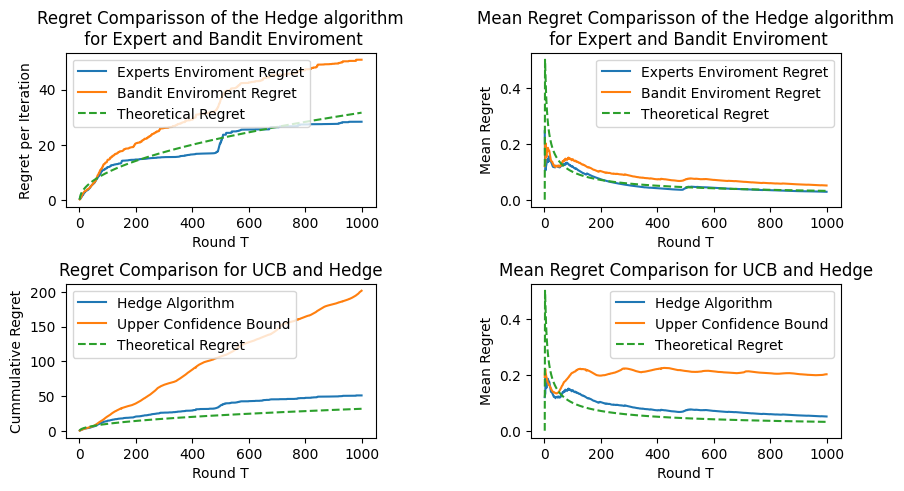

In [11]:
# ------------------------------------------------------------------------------------------

# Plots - Results
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
# Part 1
axs[0][0].set_title(
    "Regret Comparisson of the Hedge algorithm\n for Expert and Bandit Enviroment")
axs[0][0].set_xlabel("Round T")
axs[0][0].set_ylabel("Cumulative Regret")
axs[0][0].plot(np.arange(1, T+1), regret_experts,
               label='Experts Enviroment Regret')
axs[0][0].plot(np.arange(1, T+1), regret_bandits,
               label='Bandit Enviroment Regret')
axs[0][0].plot(np.arange(1, T+1), Theoretical_Regret,
               linestyle='--', label='Theoretical Regret')
axs[0][0].legend()
# Part 2
axs[1][0].set_title("Regret Comparison for UCB and Hedge")
axs[1][0].set_xlabel("Round T")
axs[1][0].set_ylabel("Cumulative Regret")
axs[1][0].plot(np.arange(1, T+1), regret_bandits, label='Hedge Algorithm')
axs[1][0].plot(np.arange(1, T+1), regret_ucb, label='Upper Confidence Bound')
axs[1][0].plot(np.arange(1, T+1), Theoretical_Regret,
               linestyle='--', label='Theoretical Regret')
axs[1][0].legend()

# ------------------------------------------------------------------------------------------
# Part 1
axs[0][1].set_title(
    "Mean Regret Comparisson of the Hedge algorithm\n for Expert and Bandit Enviroment")
axs[0][1].set_xlabel("Round T")
axs[0][1].set_ylabel("Mean Regret")
axs[0][1].plot(np.arange(1, T+1), mean_regret_experts,
               label='Experts Enviroment Regret')
axs[0][1].plot(np.arange(1, T+1), mean_regret_bandits,
               label='Bandit Enviroment Regret')
axs[0][1].plot(np.arange(1, T+1), mean_Theoretical_Regret,
               linestyle='--', label='Theoretical Regret')
axs[0][1].legend()
# Part 2
axs[1][1].set_title("Mean Regret Comparison for UCB and Hedge")
axs[1][1].set_xlabel("Round T")
axs[1][1].set_ylabel("Mean Regret")
axs[1][1].plot(np.arange(1, T+1), mean_regret_bandits, label='Hedge Algorithm')
axs[1][1].plot(np.arange(1, T+1), mean_regret_ucb,
               label='Upper Confidence Bound')
axs[1][1].plot(np.arange(1, T+1), mean_Theoretical_Regret,
               linestyle='--', label='Theoretical Regret')
axs[1][1].legend()
plt.show()


Here we plot the 4 graphs. The first row has 2 graphs. The one on the left depicts the cummulative regrets of the theoretical sqrt(T), the Hedge algorithm on the experts enviroment and the Hedge algorithm on the adversarial Bandits envrioment. The one on the right has the mean regrets for these 3 cases.
The second row has also 2 graphs. The one on the left depicts the cummulative regrets of the UCB algorithm and Hedge algorithm applied to the adversarial bandits enviroment and the theoretical cummulative regret. And the one on the right depicts the mean regrets of these 3 cases.
(by changing the horizon we can study the 2 requested cases : T = 1000 and for the whole dataset T = 7000)